# Statistical Analysis Methods (SAM) for a Silent Period Evaluation

Our hospital's new Silent Period REB asks users to answer several questions regarding the statistical properties of their models and how they were calibrated. This notebook will help SK users to better answer the following question for a binary classifier:

> Please provide details about a power calculation to support the determination of the trial’s endpoint.

This notebook will show how to:

1. Calibrate your model for an appropriate binary classification metric
2. Specify a hypothesis test to be carried out during the silent period which will establish a certain performance level
3. Estimate the number of samples you will need (power calculation)

<span style="color:red">
    <h2> WARNING No. 1: Assumptions</h2>
</span>

The calculations and statistics in this notebook work only under strict assumptions. Some of these asusmptions include: 1) the data is independently and identically (IID) drawn, 2) the data generating process is stable (i.e. no dataset shift), 3) there are no technical confounders, and 4) the binary outcome comes from a binomial distribution. Statistics necessarily relies on assumptions, and while small violations have a small impact, larger issues with your dataset cannot be reconciled by this notebook.

## (1) Background

If you are ready to evaluate your model in silent mode it means you have already built a machine learning algorithm and obtained a satisfactory performance on a test set. This notebook will assume you have constructed your test set in a way that is representative of the population you expect to exist during the prospective silent period. 

<span style="color:red">
    <h2> WARNING No. 2: Data</h2>
</span>

The test set you provide for this notebook should be *representative* of future data. In the strictest statistical sense, this means that literally your test set needs to be drawn from the same distribution as all future observations. In practice it is impossible to know this for sure, but there are obvious examples where your test set will not be representative. For example, if your classifier was trained before COVID-19 on a clinical population, it is likely that the number of patients, and possibly the characteristics of those patients, has changed since March 2020. If your test set comes from a study population that is enriched for certain age categories, sex, or genotypes, then again, your test set will not be representative. If you know your test set is not representative, it is important to draw stratified sub-samples or weight your loss function. There is no one way to go about doing this, so please contact myself or someone with statistics training to help you if you do not feel comfortable doing it yourself. The following are factors you may want to condition/weight your test set construction on:

1. Patient characteristics
2. Label balance
3. Missingness
4. Label noise

### (1.B) Calibrating your model

The numeric choice of threshold that will map your model's probability score to a discrete positive or negative label. This threshold choice will determine your model's long-run statistical performance (e.g. sensitivity, specificity, etc). Two performance criteria need to be chosen in this SAM notebook:

1. What is the level of performance you want your model to have? (e.g. 90% sensitivity). This will be referred to as "model performance".
2. What performance will be sufficient to ensure the model is "acceptable" for the study? For example, if the model sensitivity is 90%, then a target performance will have to be something less than 90%: *at least* 85%, for example. This will be referred to as "trial performance".

It is essential that model performance is **better** than trial performance. This is because the difference between these two values will ultimately determine how many samples will be needed to complete your silent trial. In the rest of this notebook we will assume a research group wants to evaluate their model based on the calculation of the positive predictive value (PPV). Specifically, they have chosen a model performance of 50% and a trial performance of 40% for the PPV.

### (1.C) Provide your performance functions

Unless you want to target the PPV, you will need to modify two functions in the `support_funs.py` script:

1. A `perf_fun` function that outputs the performance metric you care about (sensitivity, specificity, etc)
2. A `thresh_find` function that takes `perf_fun` and finds a threshold for a given target

Please see the comments in the script for additional information. I have also defined a `bootstrap` class that should work if your `thresh_find` function is constructed in the same manner. In the code block below you will also need to adjust:

1. Model performance (`model_perf`)
2. Trial performance (`trial_perf`)
3. Pick a type-I error rate `type1` for the threshold
4. Power of the study (`power`) - I suggest you leave this as is.
5. Type-I error rate of the study (`alpha`) - I suggest you leave this as is.

The type-I error rate is in reference to the threshold choice. Specifically, this value determines how often the statistically chosen threshold will have a performance WORSE than what you expect. For example, if you want 90% sensitivity, and choose a type-1 error rate to be 20%, then 20% of the time the threshold that is chosen will obtain a long-run sensitivity worse than 90%.  Note that lowering the type-I error rate will result in an increasingly conservative threshold, so we suggest a strong but not overly stringent number like 10-20%. If you pick a value of `model_perf` that is very close to `trial_perf`, you will likely need tens of thousands of samples to obtain a reasonable power. I suggest a reasonable difference. Though this will depend on the statistic, I would not go lower than a 5% spread.

<span style="color:red">
    <h2> WARNING No. 3: Performance functions</h2>
</span>

Your performance function, `perf_fun`, should be monotonically increasing (or decreasing) with respect to the threshold. In the case of the PPV, we can allow for some slight discontinuities since asymptotically the PPV curve should be monotonically increasing with respect to the threshold function. Another way to think about this is that the relationship should be roughly monotonic in the range of performance scores that are cared about. Please examine the distribution of Figure 1 to determine if your data satisfies this condition.

You may also be unsure of how to choose the performance level. Usually this target is informed by your clinical leads who may want a certain sensitivity, or a bound on the number of false positives. If you are able to assess the relative cost of true positives to false positives (or true negatives to false negatives), then the positive (negative) predictive value is a useful target. Such assessments may require a detailed health economic analysis.

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import os
import plotnine
from plotnine import *
from scipy import stats
from scipy.optimize import minimize_scalar
import importlib
import support_funs
importlib.reload(support_funs)

# --- (1) LOAD TEST SET --- #
"""
THIS IS SIMULATED DATA, PLEASE LOAD IN YOUR ACTUAL DATA WITH COLUMN NAMES y, score AND OTHER GROUPS FOR POST-HOC ANALYSIS
"""
# !!!!!!!!!!!!!!!!!!! PLEASE ADJUST !!!!!!!!!!!!!!!!!!!! #
np.random.seed(1234)
df = pd.DataFrame({'y':np.append(np.repeat(0,100),np.repeat(1,10)),
                  'score':np.append(np.random.randn(100),np.random.randn(10)+2),
                  'group_1':np.random.choice(['a','b'],110),
                  'group_2':np.random.choice(['c','d'],110)})
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! #

# !!!!!!!!!!!!!!!!!!! PLEASE ADJUST IN support_funs.py !!!!!!!!!!!!!!!!!!!! #
# --- (1) PEFORMANCE FUNCTION --- #
from support_funs import perf_fun

# --- (2) THRESHOLD FINDER --- #
from support_funs import thresh_find
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! #

# --- (3) BOOTSTRAPPER --- #
from support_funs import bootstrap

# !!!!!!!!!!!!!!!!!!! PLEASE ADJUST !!!!!!!!!!!!!!!!!!!! #
model_perf = 0.5
trial_perf = 0.4
type1 = 0.2
trial_power = 0.8
alpha = 0.05
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! #

### (1.D) Check calibration 

Now that you have chosen the model and trial performance metrics, compare how these align to the range of possible calibration choices possible on your test set by looking at Figure 1. Note that if you model or trial targets are too high or low, relative to what you can obtain, they will be poor choices. 

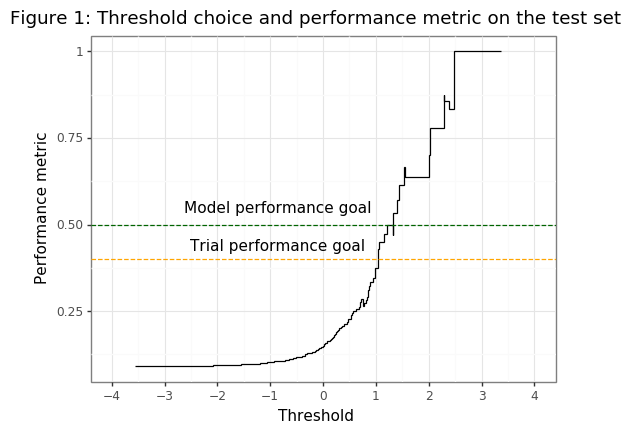

<ggplot: (8747394057789)>

Desired performance is 0.500, actual empirical performance is: 0.500



In [2]:
thresh_seq = np.sort(df.score.unique())
df_seq = pd.DataFrame({'perf':[perf_fun(df.y, df.score, thresh=tt) for tt in thresh_seq],'thresh':thresh_seq})
thresh_emp = thresh_find(df.y, df.score, target=model_perf)

# If you fail this assertion, you cannot obtain this performance
assert df_seq.perf.max() > model_perf
# Assuming higher values of the perf_fun are better
assert trial_perf < model_perf

plotnine.options.figure_size = (6,4.5)
tmp_lbls = pd.DataFrame({'x':np.repeat(df_seq.thresh.quantile(0.15),2),
                    'y':[model_perf, trial_perf],
                    'lbls':['Model performance goal', 'Trial performance goal']})
gg_thresh = (ggplot(df_seq, aes(x='thresh',y='perf')) + theme_bw() + 
             geom_step() +  labs(x='Threshold', y='Performance metric') + 
             ggtitle('Figure 1: Threshold choice and performance metric on the test set') + 
             geom_hline(yintercept = model_perf, color='darkgreen', linetype='--') + 
             geom_hline(yintercept = trial_perf, color='orange', linetype='--') + 
             #geom_vline(xintercept = thresh_emp, color='darkgreen', linetype='--') + 
             geom_text(aes(x='x',y='y*1.1',label='lbls'),data=tmp_lbls,inherit_aes=False) + 
             scale_x_continuous(limits=[-4,4],breaks=list(np.arange(-4,4.1,1))))
print(gg_thresh)

# Check that threshold finder gets desired (empirical) performance
print('\nDesired performance is %0.3f, actual empirical performance is: %0.3f\n' % 
     (model_perf,perf_fun(df.y, df.score, thresh=thresh_emp)))

## (2) Finding the right threshold for model performance

Figure 1 shows that on this example test set dataset, a threshold of around 1.2 obtains a 50% PPV. However, were this threshold to be evaluated on another test set from the same data generating process, the observed PPV would be different (from the natural variation that occurs for sampling). As the chosen threshold is a random variable, our statistical goal is to find an upper-bound (or lower-bound) of the threshold, which in expectation, will obtain a PPV of at least `model_perf`, `1-type1` percent of the time. 

This is where the bias-corrected and accelerated bootstrap ([BCa](https://www.jstor.org/stable/2289144)) comes in. It will use your test set to estimate the natural variation in the data generating process and will pick a more conservative threshold than the empirical one. Note that if higher values of your threshold "improve" your performance function, than a "conservative" threshold will be higher than the empirical. And vice versa when lower thresholds are better (e.g. specificity).

Note that it is advisable to make `nboot` in the `bootstrap` class very large, since this is one source of variation (the number of bootstraps) that can be basically eliminated with a large number of resamples. In this case I am also making use of the `strata` argument in the `fit` method because I assuming that the test set label balance matches the overall dataset (training and validation). In other words, I do not want label balance to be another source of variation because I assume it is basically known. However, if you are unsure of your long-run label balance, do not use the stratification. In the code below I run 10K bootstrapped simulations and then ask for the upper bound of the confidence interval (i.e. the 80th percentile).

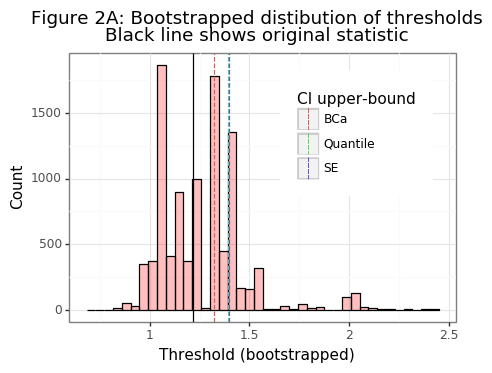

<ggplot: (8747385555905)>


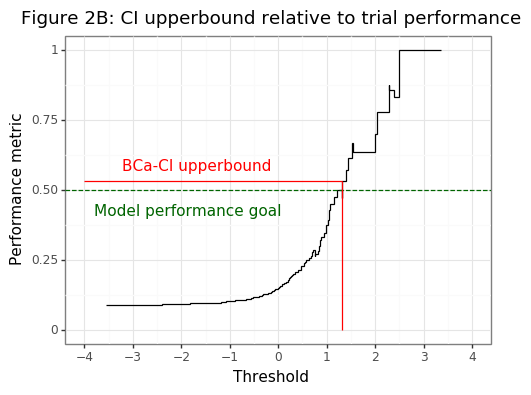

<ggplot: (8747385510873)>


In [3]:
sim = bootstrap(nboot=10000, func=thresh_find)

# !!!!!!!!!!!!!!!!!!! PLEASE ADJUST !!!!!!!!!!!!!!!!!!!! #
sim.fit(df.y.values, df.score.values, target=model_perf, strata=df.y.values)
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! #

sim.get_ci(alpha=type1,symmetric='upper')
di_method = {'bca':'BCa', 'quantile':'Quantile', 'se':'SE'}
df_ci = pd.DataFrame.from_dict(sim.di_ci,orient='index').reset_index().rename(columns={0:'thresh','index':'method'})
df_ci = df_ci.assign(method = lambda x: x.method.map(di_method))
df_ci = df_ci.assign(ppv=df_ci.apply(lambda x: perf_fun(df.y, df.score, thresh=x.thresh),1))
df_ci = df_ci.assign(thresh2=df_ci.apply(lambda x: thresh_find(df.y, df.score, target=x.ppv),1))
thresh_bca = df_ci.query('method=="BCa"').thresh.values[0]

title = 'Figure 2A: Bootstrapped distibution of thresholds\nBlack line shows original statistic'
plotnine.options.figure_size = (5,3.5)
gg_bs = (ggplot(pd.DataFrame({'thresh':sim.store_theta}), aes(x='thresh')) + 
         theme_bw() + geom_histogram(bins=40,color='black',fill='red',alpha=0.25) + 
         labs(x='Threshold (bootstrapped)',y='Count') + ggtitle(title) + 
         geom_vline(xintercept=sim.theta,color='black') + 
         geom_vline(aes(xintercept='thresh',color='method'),data=df_ci,linetype='--') + 
         scale_color_discrete(name='CI upper-bound') + 
         theme(legend_position=(0.70, 0.65)))
print(gg_bs)
tmp_ci = df_ci.assign(thresh0=-4,y0=0,lbl='BCa-CI upperbound').query('method=="BCa"')

plotnine.options.figure_size = (5.5,4)
gg_emp = (ggplot(df_seq, aes(x='thresh',y='perf')) + theme_bw() + 
             geom_step() +  labs(x='Threshold', y='Performance metric') + 
             ggtitle('Figure 2B: CI upperbound relative to trial performance') + 
             scale_x_continuous(limits=[-4,4],breaks=list(np.arange(-4,4.1,1))) + 
          geom_hline(yintercept = model_perf, color='darkgreen', linetype='--') + 
          geom_segment(aes(x='thresh0',xend='thresh2',y='ppv',yend='ppv'),data=tmp_ci,color='red') +
          geom_segment(aes(x='thresh2',xend='thresh2',y='y0',yend='ppv'),data=tmp_ci,color='red') + 
          geom_text(aes(x='thresh-3',y='ppv*1.1',label='lbl'),data=tmp_ci,color='red') + 
          geom_text(aes(x='x-1',y='y*0.85',label='lbls'),data=tmp_lbls.head(1),color='darkgreen'))
print(gg_emp)

Figure 2A shows the different thresholds generated through the bootstrap. In my case, the distribution of the threshold is clearly non-normal, skewed, and biased. To correct for this, the BCa bootstrap adjusts the percentiles used to ensure  (close-to) valid inference measures for many types of challenging statistics. Figure 2B shows that the upper-bound of the BCa threshold gets an empirical PPV of 53%. In other words, a slightly higher empirical PPV is required (than the of 50%) to minimize the risk of a type-I threshold error to 20%.

## (3) Calculating the sample size (power analysis)

The previous section's calculations have no bearing on the power analysis. The threshold choice ensures that the empirical threshold is at least the level of the model performance (most the time). Instead the power analysis is based only on the spread between the model and trial performance (`model_perf - trial_perf`). Recall that the difference between two binomial proportions (for a large enough sample size) is approximately normally distribution. Define $\hat{p}$ as the empirical PPV. Then under the null that $p = \texttt{trial_perf}\leq p_t$, the difference between these should be mean zero:

$$
\begin{align*}
\hat{p} &\sim N\big(p_t, \sigma_t \big), \hspace{3mm} \sigma_t = \sqrt{\frac{p_t(1-p_t)}{n}} \\ 
z_0 &= \frac{\hat{p} - p_t}{\sigma_t} \sim N(0,1)
\end{align*}
$$

If we construct a one-sided hypothesis test, we will reject the null in favour of $p > p_t$ if $z_t > \Phi^{-1}(1-\alpha) = t_\alpha$, where $\alpha$ is the type-1 error for this test (`alpha`). The power calculation, as follows, where $\beta$ is 1-Power (type-II error), and $\Phi$ is the standard normal CDF.

$$
\begin{align*}
z_A &= \frac{\hat{p} - p_m}{\sigma_m} \sim N(0,1) \\
\beta &= P(z \leq t_\alpha) \\
&= P(\hat{p} \leq \sigma_t\cdot t_\alpha + p_t ) \\ 
&= P\Bigg(\frac{\hat{p}-p_m}{\sigma_m} \leq \frac{\sigma_t\cdot t_\alpha - (p_m- p_t)}{\sigma_m} \Bigg) \\
&= \Phi\Bigg(\frac{\sigma_t\cdot t_\alpha - (p_m- p_t)}{\sigma_m} \Bigg)
\end{align*}
$$

Because $\sigma_{m,t}$ are functions of $n$, the goal is to find:

$$
\begin{align*}
n^* &= \inf_n\{ n: \beta(n) \leq 1-\text{Power}  \}
\end{align*}
$$

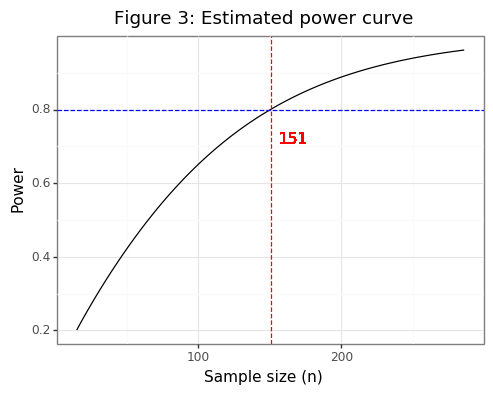

<ggplot: (8747536790441)>
Estimated sample size needed for 0.8 power: 151


In [4]:
def beta_fun(n, pt, pm, alpha):
    ta = stats.norm.ppf(1-alpha)
    sigma_t = np.sqrt(pt*(1-pt)/n)
    sigma_m = np.sqrt(pm*(1-pm)/n)
    Phi = stats.norm.cdf( (sigma_t*ta-(pm-pt))/sigma_m )
    return Phi
    
n_star = minimize_scalar(fun=lambda x: (beta_fun(n=x, pt=trial_perf, pm=model_perf, alpha=alpha) - (1-trial_power))**2,
                bounds=(1,1000),method='Bounded').x
n_star = int(np.ceil(n_star))

n_seq = np.unique(np.linspace(n_star*0.1, n_star*1.9,100).astype(int))
power_seq = 1-beta_fun(n=n_seq, pt=trial_perf, pm=model_perf, alpha=alpha)
df_power = pd.DataFrame({'power':power_seq, 'n':n_seq})

plotnine.options.figure_size = (5.5,4)
gg_power = (ggplot(df_power,aes(x='n',y='power')) + theme_bw() + 
           geom_line() + labs(x='Sample size (n)', y='Power') + 
           ggtitle('Figure 3: Estimated power curve') + 
           geom_vline(xintercept=n_star,color='red',linetype='--') + 
           geom_text(x=n_star*1.1,y=trial_power*0.9,label=n_star,color='red') + 
           geom_hline(yintercept=trial_power,linetype='--',color='blue'))
print(gg_power)

print('Estimated sample size needed for %0.1f power: %i' % (trial_power,n_star)) 

According to this analysis I'll need 151 samples to reject the null of a PPV $\leq$ 40%, 80% of the time. **NOTE!!** It's important to understand that a "sample" in this case means an observation in the statistic. For the PPV statistic, this means a predicted positive. But since my algorithm makes a prediction on only 14% of observations (see below), the overall number of observations in the dataset will need to be around 7 times that number! If your statistic is sensitivity, for example, you'll need to multiply the number of samples by 1/True Positive Rate. 

Because I am unsure of my actual predicted positive rate (as this is something I cannot obtain from my training/validation sets as it would be biased), I choose to pick a more conservative estimate (i.e. something lower). This will inflate the sample size, but ensure that power is not underestimated. According the analysis, I'll need 1510 observations.

In [5]:
np.random.seed(1234)
pred_pos_raw = df.query('score >= @thresh_bca').shape[0] / df.shape[0]
# !!!!!!!!!!!!!!!!!!! PLEASE ADJUST !!!!!!!!!!!!!!!!!!!! #
pred_pos_rate = np.quantile([np.mean(df.score.sample(frac=1,replace=True)>thresh_bca) for z in range(10000)], type1)
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! #
print('Predicted positive rate: %0.3f\nAjdusted rate: %0.3f' % (pred_pos_raw, pred_pos_rate))

Predicted positive rate: 0.136
Ajdusted rate: 0.100


### (3.B) Conclusion

Congratulations at this point you are done! You know the threshold you'll need for the trial: `thresh_bca` and the number of samples: `n_star_ppv`.

In [6]:
n_star_ppv = int(n_star/pred_pos_rate)
print('Your threshold is: %0.3f and you will need %i samples' % (thresh_bca,n_star_ppv))

Your threshold is: 1.321 and you will need 1510 samples


## (4) Simulation demonstration

The following section is meant to show how the BCa-CI upper-bound works in a statistical sense, since the data generating process is known in this case. This subsection can be deleted for your analysis.

Each simulation represents a theoretical test set and subsequent trial. The test set has 110 patients (10 positive labels and 100 negative labels), with a mean Gaussian difference of two. The trial period has 1510 samples based on my calculations above. The test set is used to find the threshold for the model performance (`model_perf`), and then a test statistic is generated using the trial performance (`trial_perf`).

Figure 4 shows that if the true threshold were known (oracle) we would have a trial power of 87%. For the realistic scenario of needing to learn the threshold, we get exactly the power we are looking for: 80.1%! Note that if we had not adjusted the `pred_pos_rate` to be more conservative, the power would have been slightly below 80% since the sample size would be underestimated.

In [ ]:
def PPV_theory(thresh, mu0, mu1, prev):
    """
    FUNCTION TO RETURN ASYMPTOTIC PPV FOR NORMALLY DISTRIBUTED SCORES
    """
    tpr = stats.norm.cdf(mu1 - thresh)
    fpr = stats.norm.cdf(mu0 - thresh)
    ppv = tpr*prev / (tpr*prev + fpr*(1-prev))
    return ppv

# Find the "ground truth" threshold to get model_perf
thresh_gt = minimize_scalar(lambda x: (PPV_theory(x,0,2,1/11)-model_perf)**2).x
# Estimate of the positive/negative class prevalence
prev = df.y.mean()

from time import time
stime = time()
np.random.seed(1234)
nsim = 1000
store_gt = np.zeros([nsim, 4])
store_bs = store_gt.copy()
for ii in range(nsim):
    # Draw data from test set to establish threshold
    y_test = np.append(np.repeat(0,100),np.repeat(1,10))
    score_test = np.append(np.random.randn(100),np.random.randn(10)+2)
    # Draw data from trial 
    n1 = stats.binom.rvs(n_star_ppv,prev)
    n0 = n_star_ppv - n1
    y = np.append(np.repeat(0,n0),np.repeat(1,n1))
    score = np.append(np.random.randn(n0),np.random.randn(n1)+2)
    # --- ground truth threshold --- #
    phat_gt = perf_fun(y, score, thresh=thresh_gt)
    n_gt = np.sum(score>thresh_gt)
    shat_gt = np.sqrt(phat_gt*(1-phat_gt) / n_gt)
    zscore_gt = (phat_gt-trial_perf)/shat_gt
    store_gt[ii] = [phat_gt, n_gt, zscore_gt, thresh_gt]
    # --- Estimated threshold --- #
    sim = bootstrap(nboot=250, func=thresh_find)
    sim.fit(y_test, score_test, target=model_perf, strata=y_test)
    sim.get_ci(alpha=type1,symmetric='upper')
    thresh_bca = sim.di_ci['bca']
    thresh_bca = min(score_test.max(), thresh_bca)
    phat_bca = perf_fun(y, score, thresh=thresh_bca)
    n_bca = np.sum(score>thresh_bca)
    shat_bca = np.sqrt(phat_bca*(1-phat_bca) / n_bca)
    zscore_bca = (phat_bca-trial_perf)/shat_bca
    store_bs[ii] = [phat_bca, n_bca, zscore_bca, thresh_bca]
    nleft, rate = nsim - (ii+1), (ii+1)/(time()-stime)
    if (ii+1) % 100 == 10:
        print('Simulation will take %0.1f more minutes (%i of %i)' % (nleft/rate/60, ii+1, nsim))
store_gt = store_gt[store_gt[:,2] != np.Inf]
store_bs = store_bs[store_bs[:,2] != np.Inf]
res = pd.concat([pd.DataFrame(store_gt,columns=['phat','n','zscore','thresh']).assign(tt='gt'),
                 pd.DataFrame(store_bs,columns=['phat','n','zscore','thresh']).assign(tt='bca')]).reset_index(None,True)
res = res.assign(pval = 1-stats.norm.cdf(res.zscore))
res.to_csv('res_SAM.csv',index=False)

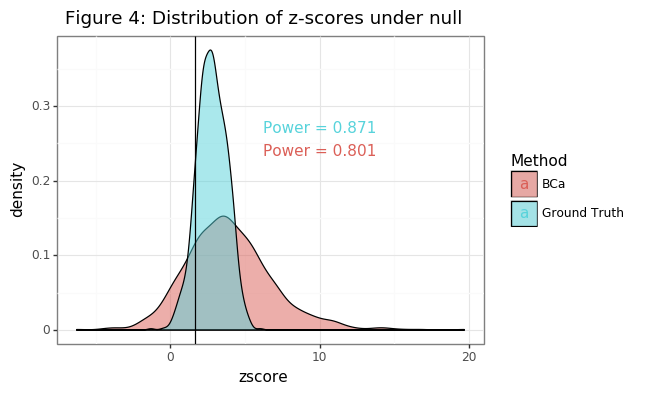

<ggplot: (8747394046265)>

In [9]:
res = res.read_csv('res_SAM.csv')
crit_val = stats.norm.ppf(1-alpha)
dat_power = res.groupby('tt').apply(lambda x: np.mean(x.pval < alpha)).reset_index().rename(columns={0:'power'})
# dat_power = dat_power.append(pd.Series({'tt':'thresh','power':crit_val}),ignore_index=True)
dat_power = dat_power.assign(x=np.repeat(10,2), y=[0.24,0.27], power=lambda x: 'Power = '+x.power.round(3).astype(str))
plotnine.options.figure_size = (5.5,4)
gg_sim = (ggplot(res, aes(x='zscore',fill='tt')) + theme_bw() + 
          geom_density(alpha=0.5) + geom_vline(xintercept=crit_val) + 
          ggtitle('Figure 4: Distribution of z-scores under null') + 
          geom_text(aes(x='x',y='y',label='power',color='tt'),data=dat_power) + 
          scale_color_discrete(name='Method',labels=['BCa','Ground Truth']) + 
          scale_fill_discrete(name='Method',labels=['BCa','Ground Truth']))
gg_sim